In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import shutil

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from models.transLOB import TransLOB
from utils.preprocessing import create_windows, generate_labels, normalize_features
from utils.training import train, validate
from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Downloading Data

In [3]:
destination = 'data/crypto/'
if not os.path.exists(destination) or len(os.listdir(destination)) == 0:
    path = kagglehub.dataset_download("martinsn/high-frequency-crypto-limit-order-book-data")
    shutil.copytree(path, destination)

## Processing Data

In [4]:
DATA_PATH = './data/crypto/BTC_1sec.csv'

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WINDOW_SIZE = 100
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 'y_30'

In [5]:
data_df = pd.read_csv(DATA_PATH, index_col=0)
data_df = data_df[:100000]
data_df['system_time'] = pd.to_datetime(data_df['system_time'])
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2021-04-08 15:19:50.115349+00:00,57780.650,2.30,3034.982045,0.000000,-1.990286e-05,-2.007593e-05,-0.000116,-0.000131,-0.000149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99996,2021-04-08 15:19:51.115349+00:00,57780.255,1.51,9894.116180,0.000000,-1.306675e-05,-1.323982e-05,-0.000121,-0.000128,-0.000143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,2021-04-08 15:19:52.115349+00:00,57783.745,0.01,19431.071140,2311.174044,-8.652952e-08,-7.329051e-05,-0.000073,-0.000155,-0.000183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,2021-04-08 15:19:53.115349+00:00,57784.955,0.01,18042.346732,0.000000,-8.652771e-08,-9.284424e-05,-0.000094,-0.000094,-0.000094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
meta_features = ['system_time', 'midpoint', 'spread', 'buys', 'sells']
distance_features = [col for col in data_df.columns if "distance" in col]
notional_features = [col for col in data_df.columns if "bids_notional" in col or "asks_notional" in col]
cancel_notional_features = [col for col in data_df.columns if "cancel_notional" in col]
limit_notional_features = [col for col in data_df.columns if "limit_notional" in col]
market_notional_features = [col for col in data_df.columns if "market_notional" in col]

In [7]:
data_df = data_df[meta_features + distance_features + notional_features]
data_df = generate_labels(data_df, HORIZONS, alpha=1e-4)
data_df = normalize_features(data_df)
data_df

,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,bids_distance_4,...,asks_notional_10,asks_notional_11,asks_notional_12,asks_notional_13,asks_notional_14,y_10,y_20,y_30,y_50,y_100
0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.062559,0.000025,0.000025,0.015261,0.004547,1,2,2,2,2
1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.062559,0.000025,0.000025,0.015261,0.004547,1,2,2,2,2
2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.062559,0.000025,0.000025,0.015261,0.004547,1,2,2,2,2
3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.062559,0.000025,0.000025,0.015261,0.004547,1,2,2,2,2
4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,-0.000288,...,0.062559,0.000025,0.000025,0.015261,0.004547,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2021-04-08 15:19:50.115349+00:00,57780.650,2.30,3034.982045,0.000000,-1.990286e-05,-2.007593e-05,-0.000116,-0.000131,-0.000149,...,0.000131,0.005390,0.007175,0.003863,0.004548,1,1,1,1,1
99996,2021-04-08 15:19:51.115349+00:00,57780.255,1.51,9894.116180,0.000000,-1.306675e-05,-1.323982e-05,-0.000121,-0.000128,-0.000143,...,0.004547,0.000102,0.000289,0.000131,0.005390,1,1,1,1,1
99997,2021-04-08 15:19:52.115349+00:00,57783.745,0.01,19431.071140,2311.174044,-8.652952e-08,-7.329051e-05,-0.000073,-0.000155,-0.000183,...,0.003863,0.000025,0.001313,0.001970,0.001970,1,1,1,1,1
99998,2021-04-08 15:19:53.115349+00:00,57784.955,0.01,18042.346732,0.000000,-8.652771e-08,-9.284424e-05,-0.000094,-0.000094,-0.000094,...,0.001313,0.001970,0.001970,0.006546,0.020704,1,1,1,1,1


In [8]:
X = data_df
X['bid0']= X['midpoint']*(1+X['bids_distance_0'])
X['ask0']= X['midpoint']*(1+X['asks_distance_0'])
X['test']=(X['ask0']-X['midpoint'])/X['midpoint']
X[['midpoint','bid0','ask0','test']]

,midpoint,bid0,ask0,test
0,56035.995,56035.99,56036.00,8.922836e-08
1,56035.995,56035.99,56036.00,8.922836e-08
2,56035.995,56035.99,56036.00,8.922836e-08
3,56035.995,56035.99,56036.00,8.922836e-08
4,56035.995,56035.99,56036.00,8.922836e-08
...,...,...,...,...
99995,57780.650,57779.50,57781.80,1.990286e-05
99996,57780.255,57779.50,57781.01,1.306675e-05
99997,57783.745,57783.74,57783.75,8.652952e-08
99998,57784.955,57784.95,57784.96,8.652771e-08


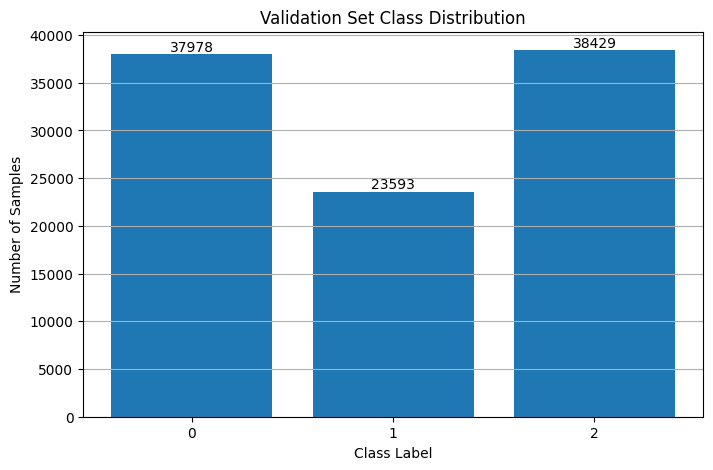

In [9]:
y_val_labels = np.array(data_df[TARGET_HORIZON])
class_counts = np.bincount(y_val_labels)

class_labels = [0, 1, 2]

plt.figure(figsize=(8,5))
plt.bar(class_labels, class_counts)

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Validation Set Class Distribution')
plt.xticks(class_labels)
plt.grid(axis='y')

for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()


In [10]:
feature_cols = [col for col in data_df.columns if col not in meta_features and not col.startswith('y_')]

X = data_df[feature_cols].values
y = data_df[TARGET_HORIZON].values

X.shape, y.shape

((100000, 63), (100000,))

In [11]:
X_windows, y_labels = create_windows(X, y, WINDOW_SIZE)
X_windows.shape

(99900, 100, 63)

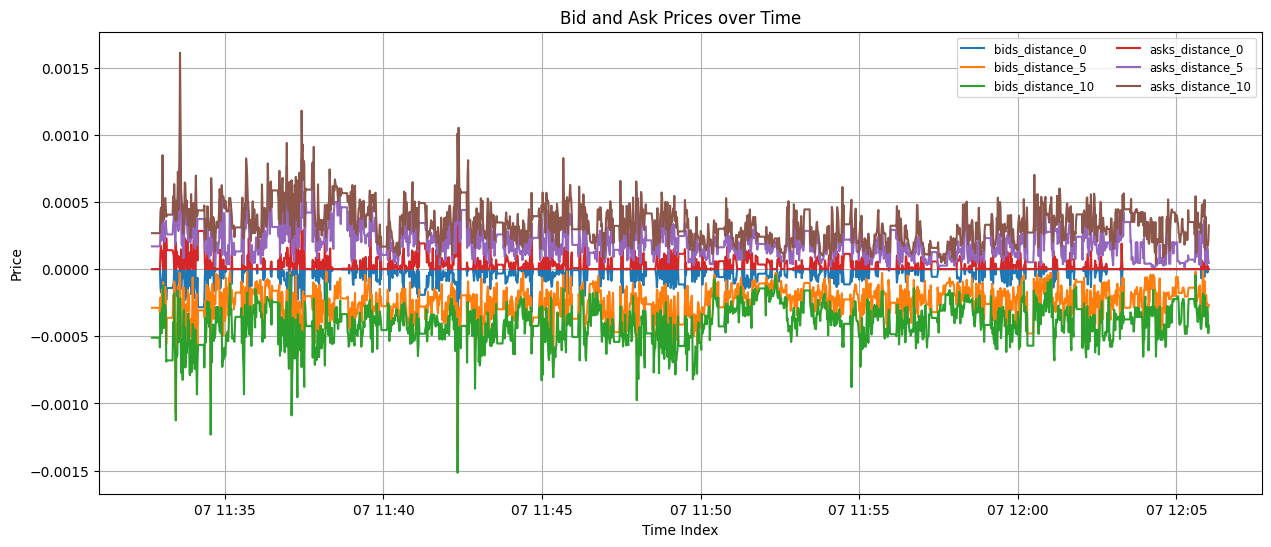

In [12]:
bid_price_cols = ['bids_distance_0','bids_distance_5','bids_distance_10']
ask_price_cols = ['asks_distance_0','asks_distance_5','asks_distance_10']

plot_range = 2000

plt.figure(figsize=(15, 6))

# Plot bids
for col in bid_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='blue', alpha=0.5)

# Plot asks
for col in ask_price_cols:
    plt.plot(data_df['system_time'][:plot_range], data_df[col].values[:plot_range], label=col)#, color='red', alpha=0.5)

plt.title('Bid and Ask Prices over Time')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid()
plt.show()

In [13]:
# distances = data_df[distance_features].melt(var_name="distance_level", value_name="distance_value")
# notionals = data_df[notional_features].melt(var_name="notional_level", value_name="notional_value")

# combined = pd.DataFrame({
#     "distance": distances["distance_value"],
#     "notional": notionals["notional_value"]
# })

# plt.figure(figsize=(14, 6))
# plt.scatter(combined["distance"], combined["notional"], alpha=0.3)
# plt.xlabel('Distance from Midprice')
# plt.ylabel('Notional Volume')
# plt.title('Price Distance vs Notional Volume')
# plt.grid(True)
# plt.show()

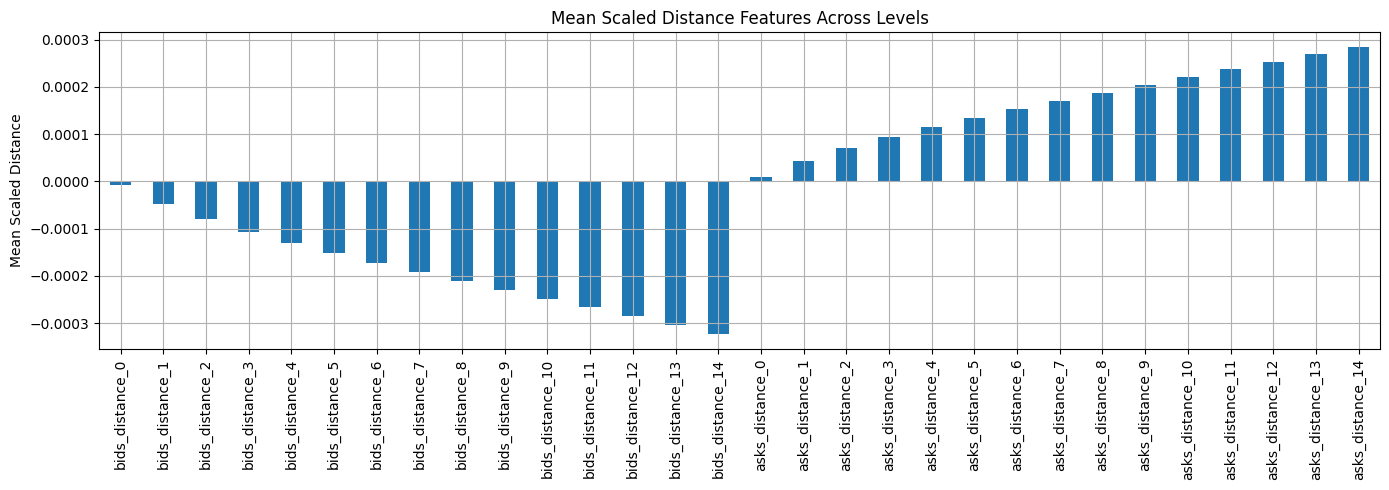

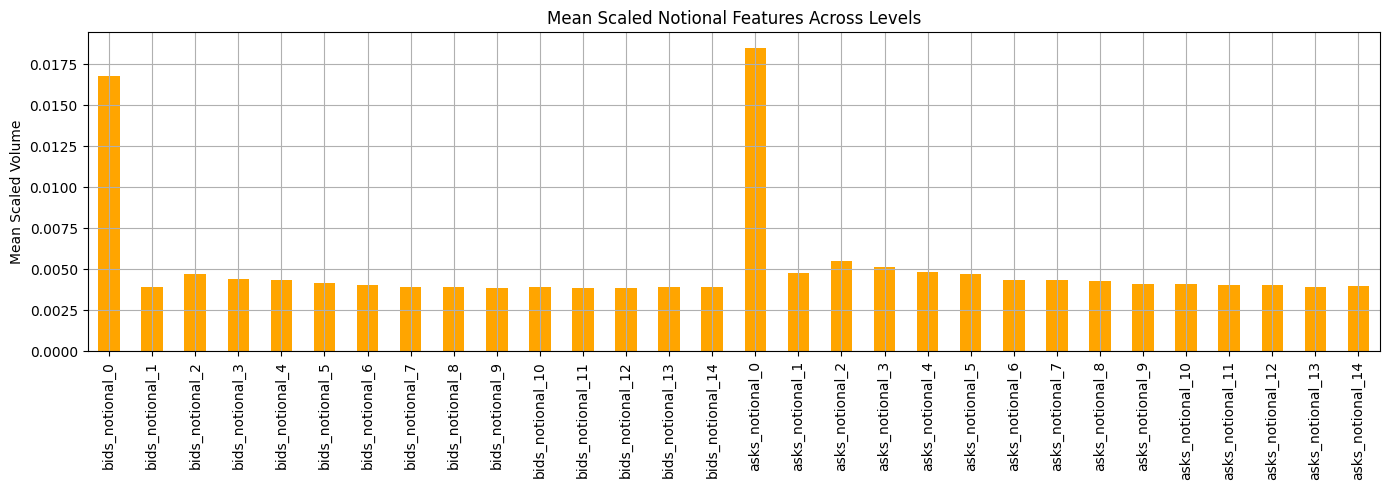

In [14]:
# Plot mean distance values across levels
plt.figure(figsize=(14, 5))
data_df[distance_features].mean().plot(kind='bar', title='Mean Scaled Distance Features Across Levels')
plt.ylabel('Mean Scaled Distance')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot mean notional values across levels
plt.figure(figsize=(14, 5))
data_df[notional_features].mean().plot(kind='bar', color='orange', title='Mean Scaled Notional Features Across Levels')
plt.ylabel('Mean Scaled Volume')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

## TransLOB

In [15]:
train_size = int(0.8 * len(X_windows))
val_size = int(0.2 * len(X_windows))

X_train, y_train = X_windows[:train_size], y_labels[:train_size]
X_val, y_val = X_windows[train_size:train_size+val_size], y_labels[train_size:train_size+val_size]
# X_test, y_test = X_windows[train_size+val_size:], y_labels[train_size+val_size:]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (79920, 100, 63), (79920,)
Validation shape: (19980, 100, 63), (19980,)


In [16]:
train_dataset = LOBDataset(X_train, y_train)
val_dataset = LOBDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
model = TransLOB(
    num_features=len(feature_cols),
    num_classes=3,
    hidden_channels=14,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [18]:
train_losses = []
val_losses = []
val_accuracies = []

epochs = 5
best_val_acc = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), './outputs/transLOB/best_model.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")


[Batch 0/1249] Train Loss: 1.1452
[Batch 1000/1249] Train Loss: 1.0716
Epoch 1/5: Train Loss 1.0705 | Val Loss 1.1078 | Val Acc 0.3547
✅ Saved best model at epoch 1 with Val Acc 0.3547
[Batch 0/1249] Train Loss: 1.0840
[Batch 1000/1249] Train Loss: 1.0618
Epoch 2/5: Train Loss 1.0692 | Val Loss 1.1229 | Val Acc 0.3515
[Batch 0/1249] Train Loss: 1.0781
[Batch 1000/1249] Train Loss: 1.0668
Epoch 3/5: Train Loss 1.0692 | Val Loss 1.1079 | Val Acc 0.3547
[Batch 0/1249] Train Loss: 1.0755
[Batch 1000/1249] Train Loss: 1.0191
Epoch 4/5: Train Loss 1.0689 | Val Loss 1.1044 | Val Acc 0.3547
[Batch 0/1249] Train Loss: 1.0583
[Batch 1000/1249] Train Loss: 1.0478
Epoch 5/5: Train Loss 1.0689 | Val Loss 1.1068 | Val Acc 0.3547


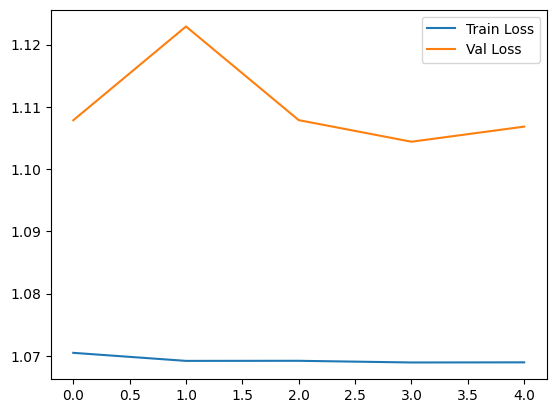

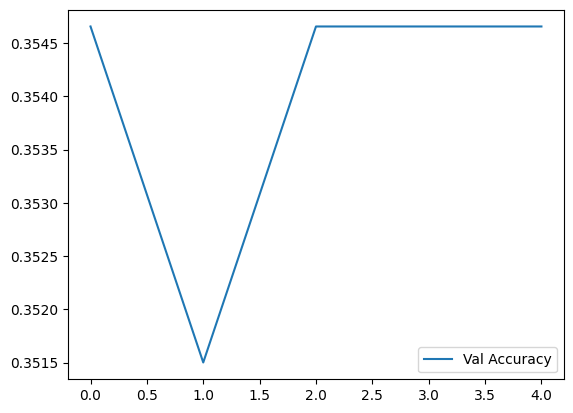

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [20]:
model.eval()

X_sample_batch, y_true_batch = next(iter(val_loader))
X_sample_batch, y_true_batch = X_sample_batch.to(device), y_true_batch.to(device)

with torch.no_grad():
    outputs = model(X_sample_batch)
    _, y_pred_batch = outputs.max(1)

# Move back to CPU for easy viewing
y_true_batch = y_true_batch.cpu().numpy()
y_pred_batch = y_pred_batch.cpu().numpy()

# Compare true vs predicted
for i in range(10):  # first 10 examples
    print(f"Sample {i}: True label = {y_true_batch[i]}, Predicted = {y_pred_batch[i]}")


Sample 0: True label = 1, Predicted = 0
Sample 1: True label = 1, Predicted = 0
Sample 2: True label = 1, Predicted = 0
Sample 3: True label = 1, Predicted = 0
Sample 4: True label = 1, Predicted = 0
Sample 5: True label = 2, Predicted = 0
Sample 6: True label = 1, Predicted = 0
Sample 7: True label = 1, Predicted = 0
Sample 8: True label = 1, Predicted = 0
Sample 9: True label = 2, Predicted = 0


In [21]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

manual_val_acc = correct / total
print(f"Manual Validation Accuracy: {manual_val_acc:.4f}")

Manual Validation Accuracy: 0.3547


In [22]:
y_val_labels = np.array(y_val)
print("Class counts:", np.bincount(y_val_labels))

Class counts: [7086 5871 7023]


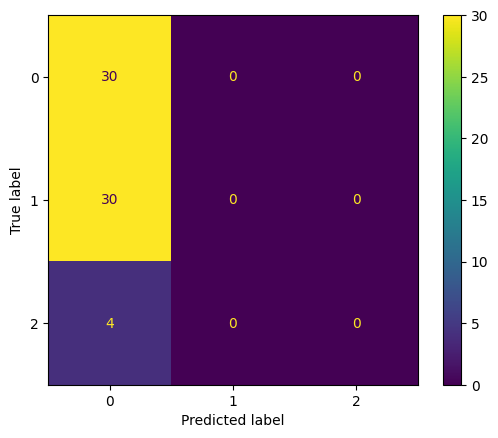

In [23]:
cm = confusion_matrix(y_true_batch, y_pred_batch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()